In [1]:
import numpy as np
from scipy.integrate import dblquad
from scipy.linalg import inv
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
import mpmath as mp

In [2]:
# resultion: Determines the precision of the results and the resolution of the generated images.
#Higher values result in greater precision but also longer computation times.
#The value used in the article was 100.
resultion=20

# low_corr: The correlation value for low-correlation scenarios, chosen arbitrarily.
low_corr=0.05

# high_corr: The correlation value for high-correlation scenarios, chosen arbitrarily.
high_corr=0.6

# vol1: The volatility of the first underlying asset, chosen arbitrarily.
vol1=0.4

# vol2: The volatility of the second underlying asset, chosen arbitrarily.
vol2=0.2

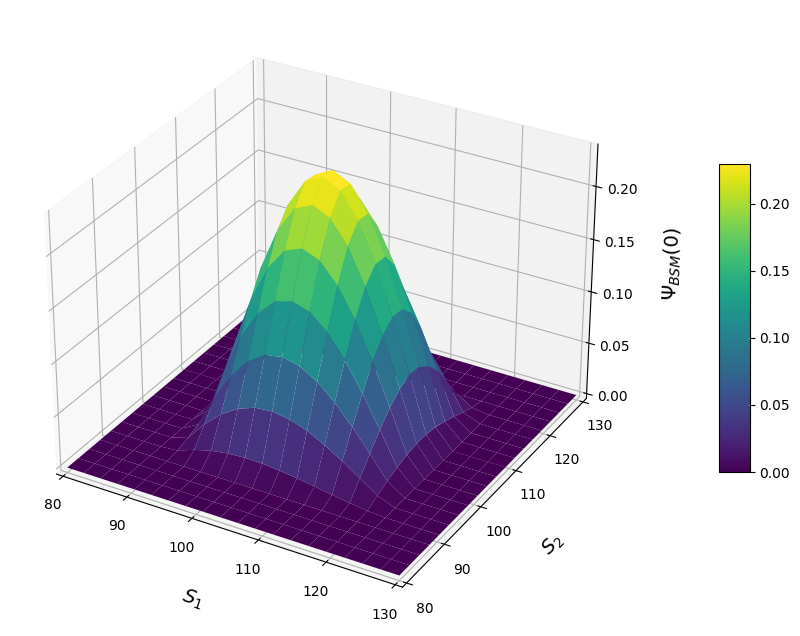

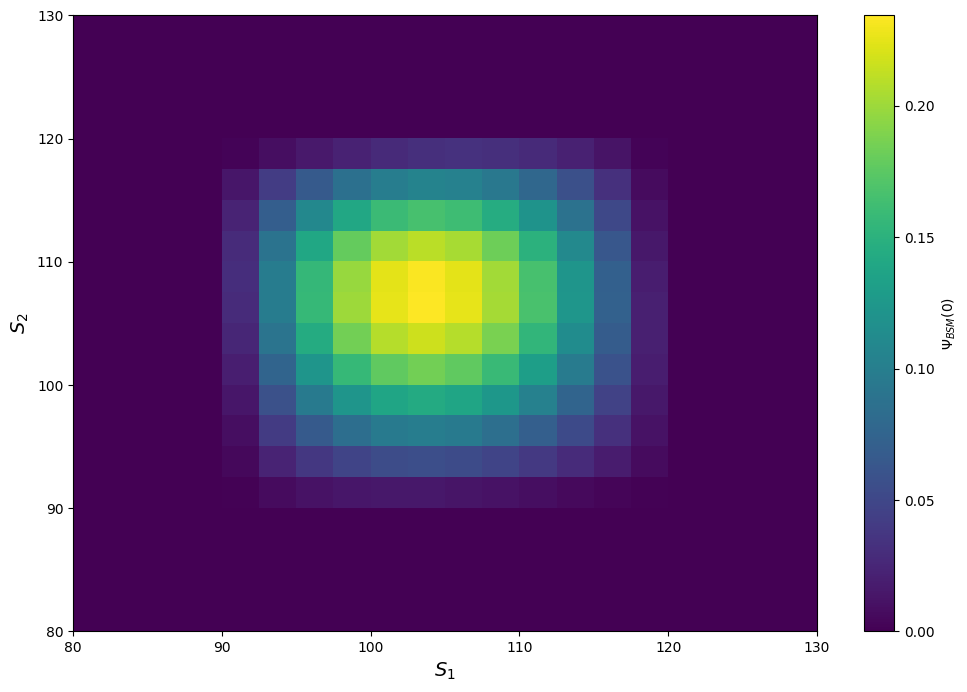

The maximum value of the option: 0.23430212624819924. Locations where the maximum occurs: (S1: 103.6842105263158, S2: 106.31578947368422)


In [3]:
S1_L1,S1_H1 = 90.0, 120.0
S2_L2,S2_H2 = 90.0, 120.0
L1, H1 = np.log(S1_L1), np.log(S1_H1)
L2, H2 = np.log(S2_L2), np.log(S2_H2)
T =0.25
r = 0.05  
K = 100.0 

S1_max=0
S2_max=0
option_max=0


sigma1, sigma2 = vol1,vol2
rho = low_corr  
Sigma = np.array([[sigma1**2, rho * sigma1 * sigma2],
                  [rho * sigma1 * sigma2, sigma2**2]])
Sigma_inv = inv(Sigma)

lambda1 = (sigma1**2 + sigma2**2 + np.sqrt((sigma1**2 - sigma2**2)**2 + 4 * rho**2 * sigma1**2 * sigma2**2)) / 2
lambda2 = (sigma1**2 + sigma2**2 - np.sqrt((sigma1**2 - sigma2**2)**2 + 4 * rho**2 * sigma1**2 * sigma2**2)) / 2

theta = 0.5 *np.arctan2(2* rho * sigma1 * sigma2, sigma1**2 - sigma2**2)

def calculate_new_boundaries(L1, H1, L2, H2, theta):

    def y1(x1, x2):
        return x1 * np.cos(theta) + x2 * np.sin(theta)

    def y2(x1, x2):
        return -x1 * np.sin(theta) + x2 * np.cos(theta)

    corners = [
        (L1, L2),
        (L1, H2),
        (H1, L2),
        (H1, H2)
    ]

    y1_values = [y1(x1, x2) for x1, x2 in corners]
    y2_values = [y2(x1, x2) for x1, x2 in corners]

    y1_min, y1_max = min(y1_values), max(y1_values)
    y2_min, y2_max = min(y2_values), max(y2_values)

    return y1_min,y1_max,y2_min, y2_max

L1_y,H1_y,L2_y,H2_y = calculate_new_boundaries(L1, H1, L2, H2, theta)

def potential_V(x1, x2):
    if L1 < x1 < H1 and L2 < x2 < H2:
        mu = np.array([r - sigma1**2 / 2, r - sigma2**2 / 2])
        return 0.5 * mu.T @ Sigma_inv @ mu + r
    else:
        return np.inf

def gamma_operator(x):
    adjustment = r - 0.5 * np.array([sigma1**2, sigma2**2])
    arg = x.T @ Sigma_inv @ adjustment
    return np.exp(arg)

def gamma_inverse_operator(x):
    adjustment = r - 0.5 * np.array([sigma1**2, sigma2**2])
    arg = x.T @ Sigma_inv @ adjustment
    return np.exp(-arg)

def phi_nm(x1, x2, n, m):
    phi=(2 / (np.sqrt((H1_y - L1_y)) * np.sqrt((H2_y - L2_y)))) * \
        np.sin(n * np.pi * (x1 * np.cos(theta) + x2 * np.sin(theta) - L1_y) / (H1_y - L1_y)) * \
        np.sin(m * np.pi * (x2 * np.cos(theta) - x1 * np.sin(theta) - L2_y) / (H2_y - L2_y))
    return phi

def phi_BSM(x1, x2, n, m):
    phi = phi_nm(x1, x2, n, m)
    x = np.array([x1, x2])
    return gamma_operator(x) * phi

def phi_BSM_inverse(x1, x2, n, m):
    phi = phi_nm(x1, x2, n, m)
    x = np.array([x1, x2])
    return gamma_inverse_operator(x) * phi

def energy_nm(n, m, x1, x2):
    return 0.5 * (lambda1 * (n**2 * np.pi**2) / (H1_y - L1_y)**2 + lambda2 * (m**2 * np.pi**2) / (H2_y - L2_y)**2) + potential_V(x1, x2)

def psi_BSM_T(x1, x2):
    return max(min(np.exp(x1), np.exp(x2)) - K, 0)

def coefficient_nm_dblquad(n, m): 

    def integrand(x2, x1):
        return phi_BSM_inverse(x1, x2, n, m) * psi_BSM_T(x1, x2)
    
    res, err = dblquad(integrand, L1, H1, lambda _x1: L2, lambda _x1: H2)
    return res

def coefficient_nm_trapz(n, m, Nx=20, Ny=20):

    x1_vals = np.linspace(L1, H1, Nx)
    x2_vals = np.linspace(L2, H2, Ny)
    
    dx1 = (H1 - L1) / (Nx - 1)
    dx2 = (H2 - L2) / (Ny - 1)
    
    sum_val = 0.0
    for i in range(Nx):
        for j in range(Ny):
            x1 = x1_vals[i]
            x2 = x2_vals[j]
            f_val = phi_BSM_inverse(x1, x2, n, m) * psi_BSM_T(x1, x2)
            sum_val += f_val
    
    result = sum_val * dx1 * dx2
    return result

def psi_BSM_0(x1, x2):
    state = 0
    for n in range(1, 11):
        for m in range(1, 11):
            cnm = coefficient_nm_trapz(n, m)
            energy = energy_nm(n, m, x1, x2)
            state += cnm * np.exp(-energy * T) * phi_BSM(x1, x2, n, m)
    return state

def compute_psi_BSM_value(i, j, S1_grid, S2_grid):
    x1, x2 = np.log(S1_grid[i, j]), np.log(S2_grid[i, j])
    result = psi_BSM_0(x1, x2)
    return result, S1_grid[i, j], S2_grid[i, j] 

S1_vals = np.linspace(80, 130, resultion)
S2_vals = np.linspace(80, 130, resultion)
S1_grid, S2_grid = np.meshgrid(S1_vals, S2_vals)
psi_BSM_values = np.zeros_like(S1_grid)

with ThreadPoolExecutor() as executor:
    futures = {
        executor.submit(compute_psi_BSM_value, i, j, S1_grid, S2_grid): (i, j)
        for i in range(S1_grid.shape[0])
        for j in range(S1_grid.shape[1])
    }
    for future in futures:
        i, j = futures[future]
        psi_BSM_values[i, j],S1,S2 =future.result()
        if psi_BSM_values[i, j] > option_max: 
            option_max = psi_BSM_values[i, j]
            S1_max = S1
            S2_max = S2

fig = plt.figure(figsize=(12, 8)) 
ax = fig.add_subplot(111, projection='3d')

surface = ax.plot_surface(S1_grid, S2_grid, psi_BSM_values, cmap='viridis', edgecolor='none')

ax.set_xlabel(r"$S_1$", fontsize=14, labelpad=15) 
ax.set_ylabel(r"$S_2$", fontsize=14, labelpad=15)
ax.set_zlabel(r"$\Psi_{BSM}(0)$", fontsize=14, labelpad=15)

cbar = fig.colorbar(surface, ax=ax, shrink=0.5, aspect=10, pad=0.1) 

ax.set_xlim([S1_grid.min(), S1_grid.max()])
ax.set_ylim([S2_grid.min(), S2_grid.max()])
ax.set_zlim([psi_BSM_values.min(), psi_BSM_values.max()])

plt.savefig("multi-asset_BSM_3D_low_corr.png", dpi=300, bbox_inches='tight')


plt.show()

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

ax.set_xlabel(r"$S_1$", fontsize=14) 
ax.set_ylabel(r"$S_2$", fontsize=14)

plt.imshow(
    psi_BSM_values,
    origin='lower',                
    extent=(
        S1_vals.min(), S1_vals.max(), 
        S2_vals.min(), S2_vals.max()
    ),
    aspect='auto',                
    cmap='viridis'                 
)


cbar = plt.colorbar()
cbar.set_label(r"$\Psi_{BSM}(0)$")
plt.savefig("multi-asset_BSM_3D_low_corr_heat.png", dpi=300, bbox_inches='tight')

plt.show()

message = f"The maximum value of the option: {option_max}. "
message += "Locations where the maximum occurs: " + ", ".join(
    [f"(S1: {S1_max}, S2: {S2_max})"]
)

print(message)

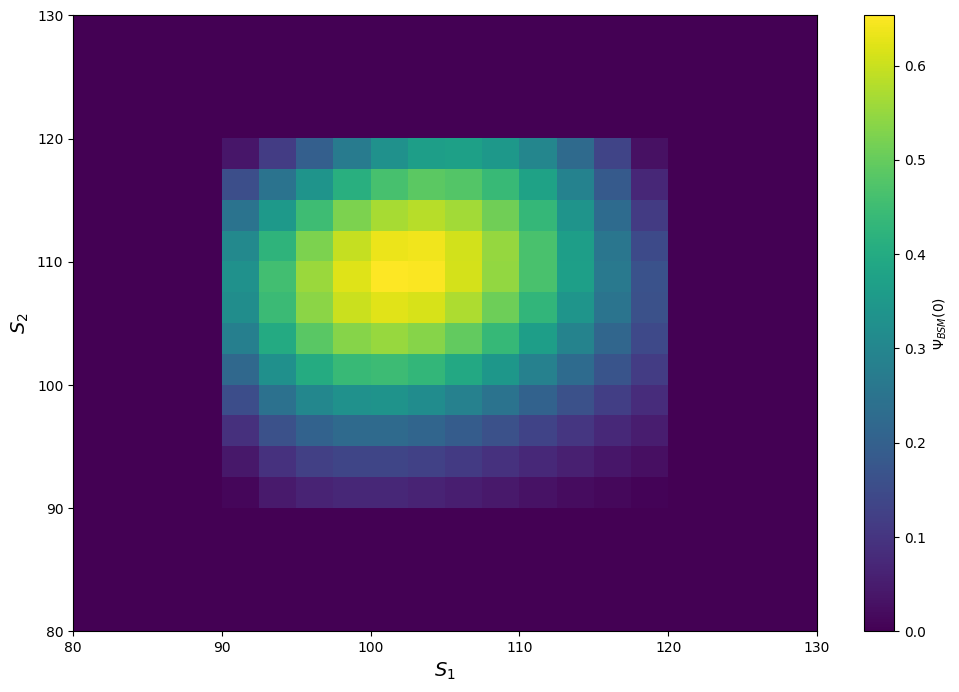

The maximum value of the option: 0.6530954565710415. Locations where the maximum occurs: (S1: 101.05263157894737, S2: 108.94736842105263)


In [4]:
S1_L1,S1_H1 = 90.0, 120.0
S2_L2,S2_H2 = 90.0, 120.0
L1, H1 = np.log(S1_L1), np.log(S1_H1)
L2, H2 = np.log(S2_L2), np.log(S2_H2)
T =0.25
r = 0.05
K = 100.0 

S1_max=0
S2_max=0
option_max=0


sigma1, sigma2 = vol1,vol2
rho = high_corr  
Sigma = np.array([[sigma1**2, rho * sigma1 * sigma2],
                  [rho * sigma1 * sigma2, sigma2**2]])
Sigma_inv = inv(Sigma)

lambda1 = (sigma1**2 + sigma2**2 + np.sqrt((sigma1**2 - sigma2**2)**2 + 4 * rho**2 * sigma1**2 * sigma2**2)) / 2
lambda2 = (sigma1**2 + sigma2**2 - np.sqrt((sigma1**2 - sigma2**2)**2 + 4 * rho**2 * sigma1**2 * sigma2**2)) / 2

theta = 0.5 *np.arctan2(2* rho * sigma1 * sigma2, sigma1**2 - sigma2**2)

def calculate_new_boundaries(L1, H1, L2, H2, theta):

    def y1(x1, x2):
        return x1 * np.cos(theta) + x2 * np.sin(theta)

    def y2(x1, x2):
        return -x1 * np.sin(theta) + x2 * np.cos(theta)

    corners = [
        (L1, L2),
        (L1, H2),
        (H1, L2),
        (H1, H2)
    ]

    y1_values = [y1(x1, x2) for x1, x2 in corners]
    y2_values = [y2(x1, x2) for x1, x2 in corners]

    y1_min, y1_max = min(y1_values), max(y1_values)
    y2_min, y2_max = min(y2_values), max(y2_values)

    return y1_min,y1_max,y2_min, y2_max

L1_y,H1_y,L2_y,H2_y = calculate_new_boundaries(L1, H1, L2, H2, theta)

def potential_V(x1, x2):
    if L1 < x1 < H1 and L2 < x2 < H2:
        mu = np.array([r - sigma1**2 / 2, r - sigma2**2 / 2]) 
        return 0.5 * mu.T @ Sigma_inv @ mu + r
    else:
        return np.inf

def gamma_operator(x):
    adjustment = r - 0.5 * np.array([sigma1**2, sigma2**2])
    arg = x.T @ Sigma_inv @ adjustment
    return np.exp(arg)

def gamma_inverse_operator(x):
    adjustment = r - 0.5 * np.array([sigma1**2, sigma2**2])
    arg = x.T @ Sigma_inv @ adjustment
    return np.exp(-arg)


def phi_nm(x1, x2, n, m):
    phi=(2 / (np.sqrt((H1_y - L1_y)) * np.sqrt((H2_y - L2_y)))) * \
        np.sin(n * np.pi * (x1 * np.cos(theta) + x2 * np.sin(theta) - L1_y) / (H1_y - L1_y)) * \
        np.sin(m * np.pi * (x2 * np.cos(theta) - x1 * np.sin(theta) - L2_y) / (H2_y - L2_y))
    return phi

def phi_BSM(x1, x2, n, m):
    phi = phi_nm(x1, x2, n, m)
    x = np.array([x1, x2])
    return gamma_operator(x) * phi

def phi_BSM_inverse(x1, x2, n, m):
    phi = phi_nm(x1, x2, n, m)
    x = np.array([x1, x2])
    return gamma_inverse_operator(x) * phi

def energy_nm(n, m, x1, x2):
    return 0.5 * (lambda1 * (n**2 * np.pi**2) / (H1_y - L1_y)**2 + lambda2 * (m**2 * np.pi**2) / (H2_y - L2_y)**2) + potential_V(x1, x2)

def psi_BSM_T(x1, x2):
    return max(min(np.exp(x1), np.exp(x2)) - K, 0)

def coefficient_nm_dblquad(n, m):

    def integrand(x2, x1):
        return phi_BSM_inverse(x1, x2, n, m) * psi_BSM_T(x1, x2)
    
    res, err = dblquad(integrand, L1, H1, lambda _x1: L2, lambda _x1: H2)
    return res

def coefficient_nm_trapz(n, m, Nx=20, Ny=20):

    x1_vals = np.linspace(L1, H1, Nx)
    x2_vals = np.linspace(L2, H2, Ny)
    
    dx1 = (H1 - L1) / (Nx - 1)
    dx2 = (H2 - L2) / (Ny - 1)
    
    sum_val = 0.0
    for i in range(Nx):
        for j in range(Ny):
            x1 = x1_vals[i]
            x2 = x2_vals[j]
            f_val = phi_BSM_inverse(x1, x2, n, m) * psi_BSM_T(x1, x2)
            sum_val += f_val
    
    result = sum_val * dx1 * dx2
    return result

def psi_BSM_0(x1, x2):
    state = 0
    for n in range(1, 11):
        for m in range(1, 11):
            cnm = coefficient_nm_trapz(n, m)
            energy = energy_nm(n, m, x1, x2)
            state += cnm * np.exp(-energy * T) * phi_BSM(x1, x2, n, m)
    return state

def compute_psi_BSM_value(i, j, S1_grid, S2_grid):
    x1, x2 = np.log(S1_grid[i, j]), np.log(S2_grid[i, j])
    result = psi_BSM_0(x1, x2)
    return result, S1_grid[i, j], S2_grid[i, j] 

S1_vals = np.linspace(80, 130, resultion)
S2_vals = np.linspace(80, 130, resultion)
S1_grid, S2_grid = np.meshgrid(S1_vals, S2_vals)
psi_BSM_values = np.zeros_like(S1_grid)

with ThreadPoolExecutor() as executor:
    futures = {
        executor.submit(compute_psi_BSM_value, i, j, S1_grid, S2_grid): (i, j)
        for i in range(S1_grid.shape[0])
        for j in range(S1_grid.shape[1])
    }
    for future in futures:
        i, j = futures[future]

        psi_BSM_values[i, j],S1,S2 =future.result()
        if psi_BSM_values[i, j] > option_max:
            option_max = psi_BSM_values[i, j]
            S1_max = S1
            S2_max = S2


fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.set_xlabel(r"$S_1$", fontsize=14)
ax.set_ylabel(r"$S_2$", fontsize=14)

plt.imshow(
    psi_BSM_values,
    origin='lower',                
    extent=(
        S1_vals.min(), S1_vals.max(), 
        S2_vals.min(), S2_vals.max()
    ),
    aspect='auto',                 
    cmap='viridis'                  
)

cbar = plt.colorbar()
cbar.set_label(r"$\Psi_{BSM}(0)$")
plt.savefig("multi-asset_BSM_3D_high_corr_heat.png", dpi=300, bbox_inches='tight')

plt.show()

message = f"The maximum value of the option: {option_max}. "
message += "Locations where the maximum occurs: " + ", ".join(
    [f"(S1: {S1_max}, S2: {S2_max})"]
)

print(message)

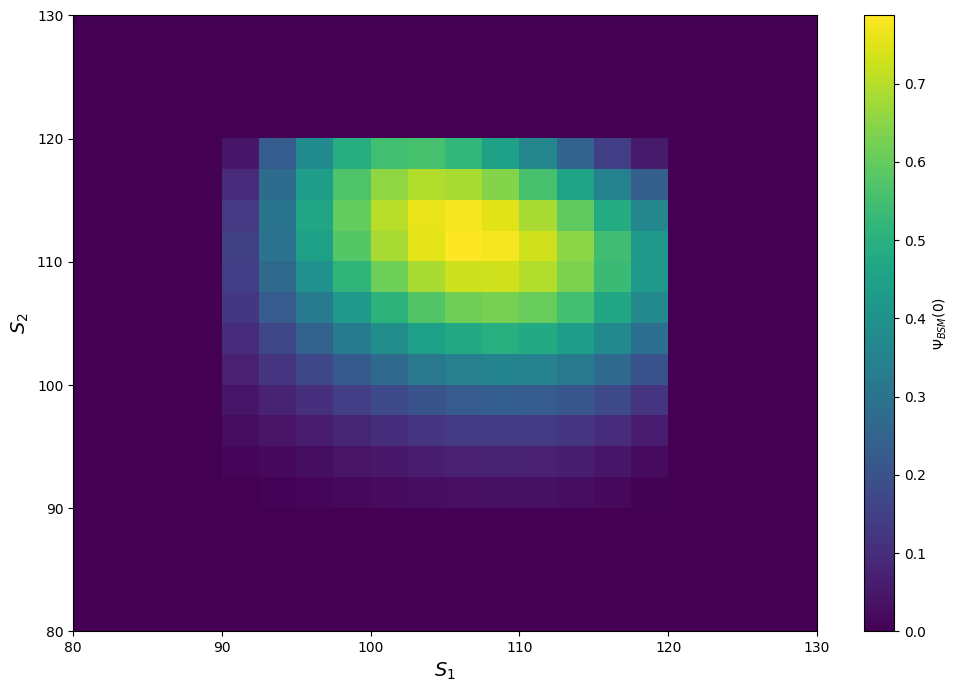

The maximum value of the option: 0.7870884739670484. Locations where the maximum occurs: (S1: 106.31578947368422, S2: 111.57894736842105)


In [5]:
S1_L1,S1_H1 = 90.0, 120.0
S2_L2,S2_H2 = 90.0, 120.0
L1, H1 = np.log(S1_L1), np.log(S1_H1)
L2, H2 = np.log(S2_L2), np.log(S2_H2)
T =0.25
r = 0.05 
K = 100.0 

S1_max=0
S2_max=0
option_max=0


sigma1, sigma2 = vol1,vol2
rho = -high_corr  
Sigma = np.array([[sigma1**2, rho * sigma1 * sigma2],
                  [rho * sigma1 * sigma2, sigma2**2]])
Sigma_inv = inv(Sigma)


lambda1 = (sigma1**2 + sigma2**2 + np.sqrt((sigma1**2 - sigma2**2)**2 + 4 * rho**2 * sigma1**2 * sigma2**2)) / 2
lambda2 = (sigma1**2 + sigma2**2 - np.sqrt((sigma1**2 - sigma2**2)**2 + 4 * rho**2 * sigma1**2 * sigma2**2)) / 2

theta = 0.5 *np.arctan2(2* rho * sigma1 * sigma2, sigma1**2 - sigma2**2)

def calculate_new_boundaries(L1, H1, L2, H2, theta):

    def y1(x1, x2):
        return x1 * np.cos(theta) + x2 * np.sin(theta)

    def y2(x1, x2):
        return -x1 * np.sin(theta) + x2 * np.cos(theta)

    corners = [
        (L1, L2),
        (L1, H2),
        (H1, L2),
        (H1, H2)
    ]

    y1_values = [y1(x1, x2) for x1, x2 in corners]
    y2_values = [y2(x1, x2) for x1, x2 in corners]

    y1_min, y1_max = min(y1_values), max(y1_values)
    y2_min, y2_max = min(y2_values), max(y2_values)

    return y1_min,y1_max,y2_min, y2_max

L1_y,H1_y,L2_y,H2_y = calculate_new_boundaries(L1, H1, L2, H2, theta)

def potential_V(x1, x2):
    if L1 < x1 < H1 and L2 < x2 < H2:
        mu = np.array([r - sigma1**2 / 2, r - sigma2**2 / 2])
        return 0.5 * mu.T @ Sigma_inv @ mu + r
    else:
        return np.inf

def gamma_operator(x):
    adjustment = r - 0.5 * np.array([sigma1**2, sigma2**2])
    arg = x.T @ Sigma_inv @ adjustment
    return np.exp(arg)

def gamma_inverse_operator(x):
    adjustment = r - 0.5 * np.array([sigma1**2, sigma2**2])
    arg = x.T @ Sigma_inv @ adjustment
    return np.exp(-arg)

def phi_nm(x1, x2, n, m):
    phi=(2 / (np.sqrt((H1_y - L1_y)) * np.sqrt((H2_y - L2_y)))) * \
        np.sin(n * np.pi * (x1 * np.cos(theta) + x2 * np.sin(theta) - L1_y) / (H1_y - L1_y)) * \
        np.sin(m * np.pi * (x2 * np.cos(theta) - x1 * np.sin(theta) - L2_y) / (H2_y - L2_y))
    return phi


def phi_BSM(x1, x2, n, m):
    phi = phi_nm(x1, x2, n, m)
    x = np.array([x1, x2])
    return gamma_operator(x) * phi

def phi_BSM_inverse(x1, x2, n, m):
    phi = phi_nm(x1, x2, n, m)
    x = np.array([x1, x2])
    return gamma_inverse_operator(x) * phi

def energy_nm(n, m, x1, x2):
    return 0.5 * (lambda1 * (n**2 * np.pi**2) / (H1_y - L1_y)**2 + lambda2 * (m**2 * np.pi**2) / (H2_y - L2_y)**2) + potential_V(x1, x2)

def psi_BSM_T(x1, x2):
    return max(min(np.exp(x1), np.exp(x2)) - K, 0)

def coefficient_nm_dblquad(n, m):

    def integrand(x2, x1):
        return phi_BSM_inverse(x1, x2, n, m) * psi_BSM_T(x1, x2)
    
    res, err = dblquad(integrand, L1, H1, lambda _x1: L2, lambda _x1: H2)
    return res

def coefficient_nm_trapz(n, m, Nx=20, Ny=20):

    x1_vals = np.linspace(L1, H1, Nx)
    x2_vals = np.linspace(L2, H2, Ny)
    
    dx1 = (H1 - L1) / (Nx - 1)
    dx2 = (H2 - L2) / (Ny - 1)
    
    sum_val = 0.0
    for i in range(Nx):
        for j in range(Ny):
            x1 = x1_vals[i]
            x2 = x2_vals[j]
            f_val = phi_BSM_inverse(x1, x2, n, m) * psi_BSM_T(x1, x2)
            sum_val += f_val
    
    result = sum_val * dx1 * dx2
    return result

def psi_BSM_0(x1, x2):
    state = 0
    for n in range(1, 11):
        for m in range(1, 11):
            cnm = coefficient_nm_trapz(n, m)
            energy = energy_nm(n, m, x1, x2)
            state += cnm * np.exp(-energy * T) * phi_BSM(x1, x2, n, m)
    return state

def compute_psi_BSM_value(i, j, S1_grid, S2_grid):
    x1, x2 = np.log(S1_grid[i, j]), np.log(S2_grid[i, j])
    result = psi_BSM_0(x1, x2)
    return result, S1_grid[i, j], S2_grid[i, j] 

S1_vals = np.linspace(80, 130, resultion)
S2_vals = np.linspace(80, 130, resultion)
S1_grid, S2_grid = np.meshgrid(S1_vals, S2_vals)
psi_BSM_values = np.zeros_like(S1_grid)

with ThreadPoolExecutor() as executor:
    futures = {
        executor.submit(compute_psi_BSM_value, i, j, S1_grid, S2_grid): (i, j)
        for i in range(S1_grid.shape[0])
        for j in range(S1_grid.shape[1])
    }
    for future in futures:
        i, j = futures[future]
        psi_BSM_values[i, j],S1,S2 =future.result()
        if psi_BSM_values[i, j] > option_max:
            option_max = psi_BSM_values[i, j]
            S1_max = S1
            S2_max = S2

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

ax.set_xlabel(r"$S_1$", fontsize=14)  
ax.set_ylabel(r"$S_2$", fontsize=14)

plt.imshow(
    psi_BSM_values,
    origin='lower',                
    extent=(
        S1_vals.min(), S1_vals.max(), 
        S2_vals.min(), S2_vals.max()
    ),
    aspect='auto',                  
    cmap='viridis'                  
)


cbar = plt.colorbar()
cbar.set_label(r"$\Psi_{BSM}(0)$")
plt.savefig("multi-asset_BSM_3D_negative_corr_heat.png", dpi=300, bbox_inches='tight')

plt.show()

message = f"The maximum value of the option: {option_max}. "
message += "Locations where the maximum occurs: " + ", ".join(
    [f"(S1: {S1_max}, S2: {S2_max})"]
)

print(message)


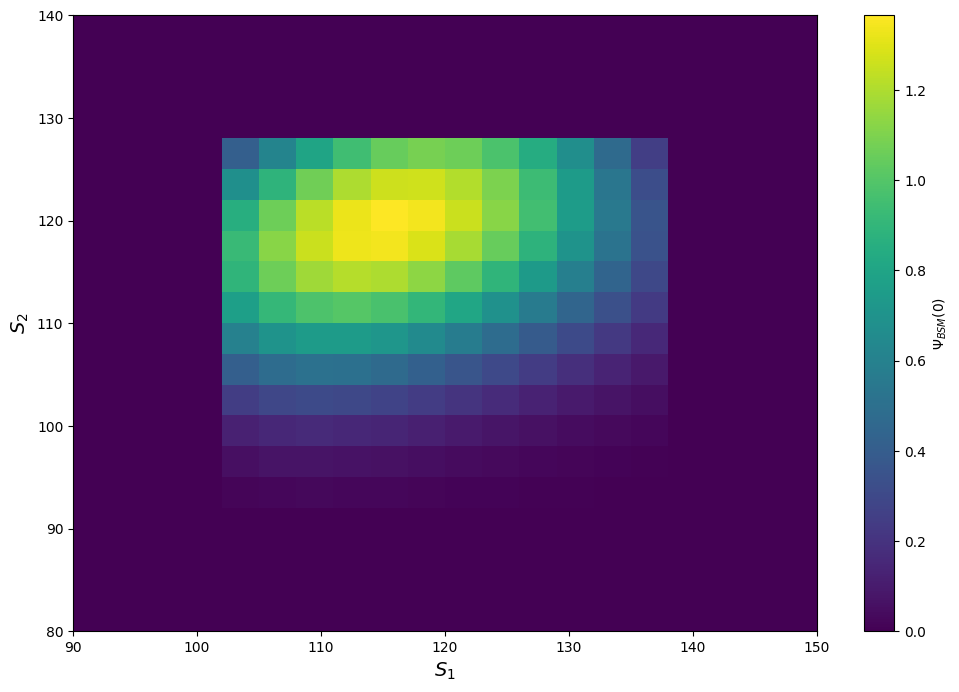

The maximum value of the option: 1.3651723834037977. Locations where the maximum occurs: (S1: 115.26315789473685, S2: 121.05263157894737)


In [6]:
S1_L1,S1_H1 = 100.0, 140.0
S2_L2,S2_H2 = 90.0, 130.0
L1, H1 = np.log(S1_L1), np.log(S1_H1)
L2, H2 = np.log(S2_L2), np.log(S2_H2)
T =0.25
r = 0.05 
K = 110.0 

S1_max= 0
S2_max=0 
option_max =0

sigma1, sigma2 = vol1,vol2
rho = high_corr 
Sigma = np.array([[sigma1**2, rho * sigma1 * sigma2],
                  [rho * sigma1 * sigma2, sigma2**2]])
Sigma_inv = inv(Sigma)

lambda1 = (sigma1**2 + sigma2**2 + np.sqrt((sigma1**2 - sigma2**2)**2 + 4 * rho**2 * sigma1**2 * sigma2**2)) / 2
lambda2 = (sigma1**2 + sigma2**2 - np.sqrt((sigma1**2 - sigma2**2)**2 + 4 * rho**2 * sigma1**2 * sigma2**2)) / 2

theta = 0.5 *np.arctan2(2* rho * sigma1 * sigma2, sigma1**2 - sigma2**2)

def calculate_new_boundaries(L1, H1, L2, H2, theta):

    def y1(x1, x2):
        return x1 * np.cos(theta) + x2 * np.sin(theta)

    def y2(x1, x2):
        return -x1 * np.sin(theta) + x2 * np.cos(theta)

    corners = [
        (L1, L2),
        (L1, H2),
        (H1, L2),
        (H1, H2)
    ]

    y1_values = [y1(x1, x2) for x1, x2 in corners]
    y2_values = [y2(x1, x2) for x1, x2 in corners]

    y1_min, y1_max = min(y1_values), max(y1_values)
    y2_min, y2_max = min(y2_values), max(y2_values)

    return y1_min,y1_max,y2_min, y2_max

L1_y,H1_y,L2_y,H2_y = calculate_new_boundaries(L1, H1, L2, H2, theta)

def potential_V(x1, x2):
    if L1 < x1 < H1 and L2 < x2 < H2:
        mu = np.array([r - sigma1**2 / 2, r - sigma2**2 / 2]) 
        return 0.5 * mu.T @ Sigma_inv @ mu + r
    else:
        return np.inf

def gamma_operator(x):
    adjustment = r - 0.5 * np.array([sigma1**2, sigma2**2])
    arg = x.T @ Sigma_inv @ adjustment
    return np.exp(arg)

def gamma_inverse_operator(x):
    adjustment = r - 0.5 * np.array([sigma1**2, sigma2**2])
    arg = x.T @ Sigma_inv @ adjustment
    return np.exp(-arg)

def phi_nm(x1, x2, n, m):
    phi=(2 / (np.sqrt((H1_y - L1_y)) * np.sqrt((H2_y - L2_y)))) * \
        np.sin(n * np.pi * (x1 * np.cos(theta) + x2 * np.sin(theta) - L1_y) / (H1_y - L1_y)) * \
        np.sin(m * np.pi * (x2 * np.cos(theta) - x1 * np.sin(theta) - L2_y) / (H2_y - L2_y))
    return phi

def phi_BSM(x1, x2, n, m):
    phi = phi_nm(x1, x2, n, m)
    x = np.array([x1, x2])
    return gamma_operator(x) * phi

def phi_BSM_inverse(x1, x2, n, m):
    phi = phi_nm(x1, x2, n, m)
    x = np.array([x1, x2])
    return gamma_inverse_operator(x) * phi

def energy_nm(n, m, x1, x2):
    return 0.5 * (lambda1 * (n**2 * np.pi**2) / (H1_y - L1_y)**2 + lambda2 * (m**2 * np.pi**2) / (H2_y - L2_y)**2) + potential_V(x1, x2)

def psi_BSM_T(x1, x2):
    return max(min(np.exp(x1), np.exp(x2)) - K, 0)

def coefficient_nm_dblquad(n, m):
    def integrand(x2, x1):
        return phi_BSM_inverse(x1, x2, n, m) * psi_BSM_T(x1, x2)
    
    res, err = dblquad(integrand, L1, H1, lambda _x1: L2, lambda _x1: H2)
    return res

def coefficient_nm_trapz(n, m, Nx=20, Ny=20):

    x1_vals = np.linspace(L1, H1, Nx)
    x2_vals = np.linspace(L2, H2, Ny)
    
    dx1 = (H1 - L1) / (Nx - 1)
    dx2 = (H2 - L2) / (Ny - 1)
    
    sum_val = 0.0
    for i in range(Nx):
        for j in range(Ny):
            x1 = x1_vals[i]
            x2 = x2_vals[j]
            f_val = phi_BSM_inverse(x1, x2, n, m) * psi_BSM_T(x1, x2)
            sum_val += f_val
    
    result = sum_val * dx1 * dx2
    return result

def psi_BSM_0(x1, x2):
    state = 0
    for n in range(1, 11):
        for m in range(1, 11):
            cnm = coefficient_nm_trapz(n, m)
            energy = energy_nm(n, m, x1, x2)
            state += cnm * np.exp(-energy * T) * phi_BSM(x1, x2, n, m)
    return state

def compute_psi_BSM_value(i, j, S1_grid, S2_grid):
    x1, x2 = np.log(S1_grid[i, j]), np.log(S2_grid[i, j])
    result = psi_BSM_0(x1, x2)
    return result, S1_grid[i, j], S2_grid[i, j] 

S1_vals = np.linspace(90, 150, resultion)
S2_vals = np.linspace(80, 140, resultion)
S1_grid, S2_grid = np.meshgrid(S1_vals, S2_vals)
psi_BSM_values = np.zeros_like(S1_grid)

with ThreadPoolExecutor() as executor:
    futures = {
        executor.submit(compute_psi_BSM_value, i, j, S1_grid, S2_grid): (i, j)
        for i in range(S1_grid.shape[0])
        for j in range(S1_grid.shape[1])
    }
    for future in futures:
        i, j = futures[future]
        psi_BSM_values[i, j],S1,S2 =future.result()
        if psi_BSM_values[i, j] > option_max: 
            option_max = psi_BSM_values[i, j]
            S1_max = S1
            S2_max = S2

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

ax.set_xlabel(r"$S_1$", fontsize=14)
ax.set_ylabel(r"$S_2$", fontsize=14)


plt.imshow(
    psi_BSM_values,
    origin='lower',              
    extent=(
        S1_vals.min(), S1_vals.max(), 
        S2_vals.min(), S2_vals.max()
    ),
    aspect='auto',                  
    cmap='viridis'                 
)


cbar = plt.colorbar()
cbar.set_label(r"$\Psi_{BSM}(0)$")
plt.savefig("multi-asset_BSM_3D_differrent_barrier_negative_corr_heat.png", dpi=300, bbox_inches='tight')

plt.show()

message = f"The maximum value of the option: {option_max}. "
message += "Locations where the maximum occurs: " + ", ".join(
    [f"(S1: {S1_max}, S2: {S2_max})"]
)

print(message)